# Анализ данных

Загрузим библиотеки

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter

Загружаем данные и посмотрим информацию о них в основном файле. Отметим что типы данных используются не оптимально и файл слишком большой.

In [2]:
train=pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [3]:
questions = pd.read_csv('data/questions.csv')
lectures = pd.read_csv('data/lectures.csv')

Переопределим типы данных согласно их содержанию. 

In [4]:
train['user_id']=train['user_id'].astype('int32')
train['content_id']=train['content_id'].astype('int16')
train['content_type_id']=train['content_type_id'].astype('boolean')
train['task_container_id']=train['task_container_id'].astype('int16')
train['user_answer']=train['user_answer'].astype('int8')
train['answered_correctly']=train['answered_correctly'].astype('int8')
train['prior_question_elapsed_time']=train['prior_question_elapsed_time'].astype('float32')
train['prior_question_elapsed_time']=train['prior_question_elapsed_time'].astype('float32')
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('boolean')

Как видим размер файла удалось уменьшить в два раза.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 boolean
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(2), float32(1), int16(2), int32(1), int64(2), int8(2)
memory usage: 3.2 GB


### Статистика по данным

In [21]:
print(f'В данных {train.user_id.nunique()} уникальных пользователя')

В данных 393656 уникальных пользователя


In [8]:
num_cont_id = train.content_id.nunique()
num_ques = train[train.content_type_id == False].content_id.nunique()

print(f'В данных {num_cont_id} разных материалов, из которых {num_ques} вопросов.')

We have 13782 content ids in our train set, of which 13523 are questions.


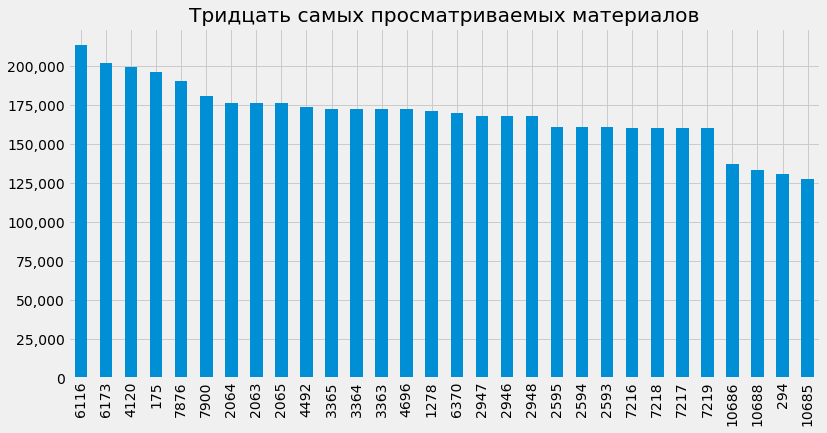

In [44]:
cids = train.content_id.value_counts()[:30]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Тридцать самых просматриваемых материалов")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

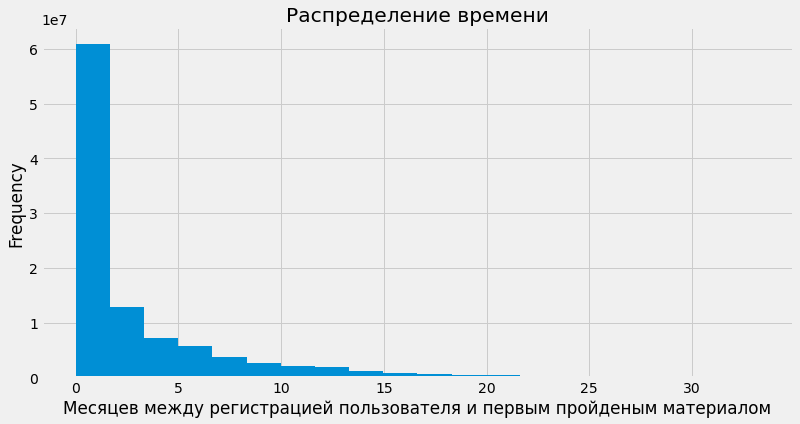

In [23]:
#1 год = 31536000000 миллисек
ts = train['timestamp']/(31536000000/12)
fig = plt.figure(figsize=(12,6))
ts.plot.hist(bins=20)
plt.title("Распределение времени")
plt.xticks(rotation=0)
plt.xlabel("Месяцев между регистрацией пользователя и первым пройденым материалом")
plt.show()

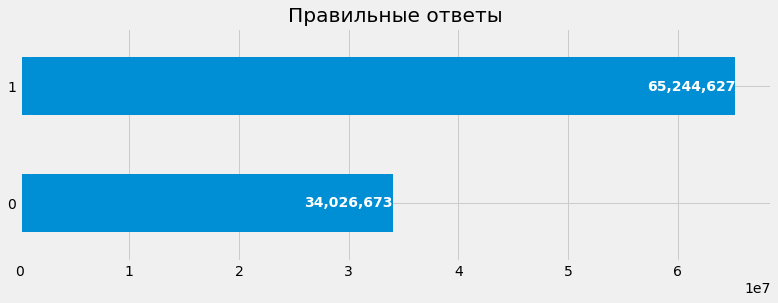

In [24]:
# Исключим лекции
correct = train[train.answered_correctly != -1].answered_correctly.value_counts(ascending=True)
fig = plt.figure(figsize=(12,4))
correct.plot.barh()
for i, v in zip(correct.index, correct.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.title("Правильные ответы")
plt.xticks(rotation=0)
plt.show()

Посмотрим на файл questions

In [25]:
questions['tags'] = questions['tags'].astype(str)

tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [item for elem in tags for item in elem]
tags = set(tags)
tags = list(tags)
print(f'В данных {len(tags)} разных тем')

В данных 266 разных тем


Посчитаем сколько в правильных и не правильных ответов было в каждом материале

In [14]:
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions.head()

correct = train[train.answered_correctly != -1].groupby(["content_id", 'answered_correctly'], as_index=False).size()
correct = correct.pivot(index= "content_id", columns='answered_correctly', values='size')
correct.columns = ['Wrong', 'Right']
correct = correct.fillna(0)
correct[['Wrong', 'Right']] = correct[['Wrong', 'Right']].astype(int)
questions = questions.merge(correct, left_on = "question_id", right_on = "content_id", how = "left")
questions.head()

,question_id,bundle_id,correct_answer,part,tags,Wrong,Right
0,0,0,0,1,"[51, 131, 162, 38]",637,6266
1,1,1,1,1,"[131, 36, 81]",809,6589
2,2,2,0,1,"[131, 101, 162, 92]",20015,24890
3,3,3,0,1,"[131, 149, 162, 29]",5067,17906
4,4,4,3,1,"[131, 5, 162, 38]",12275,19461


Посмотрим на топ самых легких и сложных тем

In [16]:
tags_df = pd.DataFrame()
for x in range(len(tags)):
    df = questions[questions.tags.apply(lambda l: tags[x] in l)]
    df1 = df.agg({'Wrong': ['sum'], 'Right': ['sum']})
    df1['Total_questions'] = df1.Wrong + df1.Right
    df1['Question_ids_with_tag'] = len(df)
    df1['tag'] = tags[x]
    df1 = df1.set_index('tag')
    tags_df = tags_df.append(df1)

tags_df[['Wrong', 'Right', 'Total_questions']] = tags_df[['Wrong', 'Right', 'Total_questions']].astype(int)
tags_df['Percent_correct'] = tags_df.Right/tags_df.Total_questions
tags_df = tags_df.sort_values(by = "Percent_correct")

C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\37

C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\37

C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\37

C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\37

C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\3721553961.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tags_df = tags_df.append(df1)
C:\Users\MaxBobrov\AppData\Local\Temp\ipykernel_19332\37

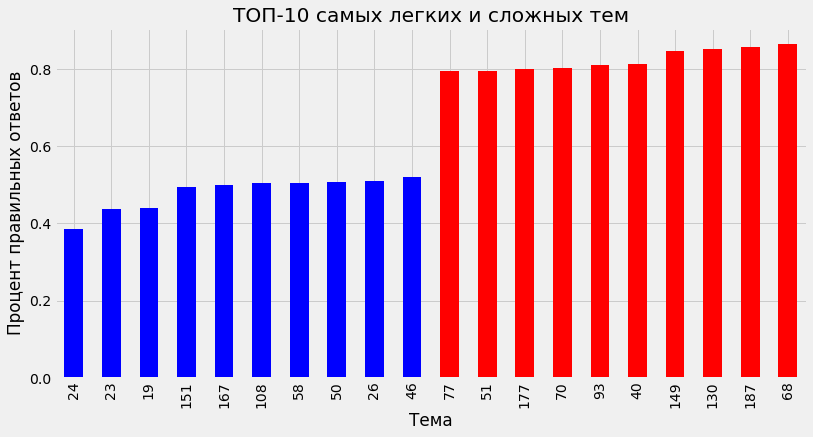

In [26]:
# Выберем нужные данные
select_rows = list(range(0,10)) + list(range(178, len(tags_df)))
tags_select = tags_df.iloc[select_rows,4]

fig = plt.figure(figsize=(12,6))
x = tags_select.index
y = tags_select.values
clrs = ['blue' if y < 0.6 else 'red' for y in tags_select.values]
tags_select.plot.bar(x, y, color=clrs)
plt.title("ТОП-10 самых легких и сложных тем")
plt.xlabel("Тема")
plt.ylabel("Процент правильных ответов")
plt.xticks(rotation=90)
plt.show()

Посмотрим матрицу корреляций парметров

                             timestamp  content_id  task_container_id  \
timestamp                     1.000000    0.052931           0.433359   
content_id                    0.052931    1.000000           0.046304   
task_container_id             0.433359    0.046304           1.000000   
user_answer                   0.000724   -0.106668           0.008532   
answered_correctly            0.025452   -0.196960           0.061129   
prior_question_elapsed_time   0.013934    0.151661          -0.013412   

                             user_answer  answered_correctly  \
timestamp                       0.000724            0.025452   
content_id                     -0.106668           -0.196960   
task_container_id               0.008532            0.061129   
user_answer                     1.000000            0.126471   
answered_correctly              0.126471            1.000000   
prior_question_elapsed_time     0.014570           -0.007900   

                             prior_ques

<AxesSubplot:>

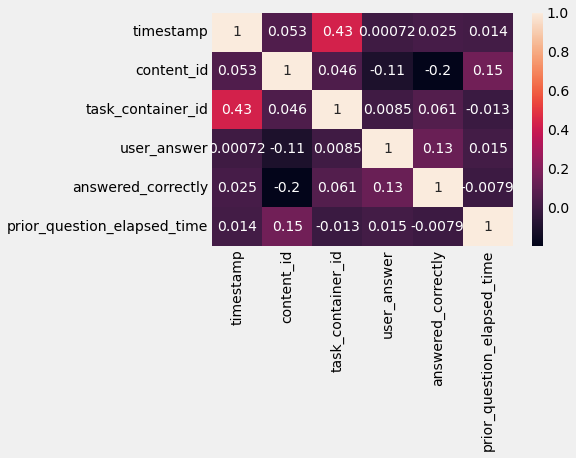

In [7]:
corr_columns = ['timestamp', 'content_id', 'task_container_id', 'user_answer', 
                'answered_correctly', 'prior_question_elapsed_time']
corr_matrix = train.loc[:,corr_columns].corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True)

Как видно особых зависимостей нет. Единственное значение 0.43 легко объясняняется тем фактом что до более поздних тем пользователь доходит позже.

Посмотрим как меняется количество правильных ответов с течением времени.

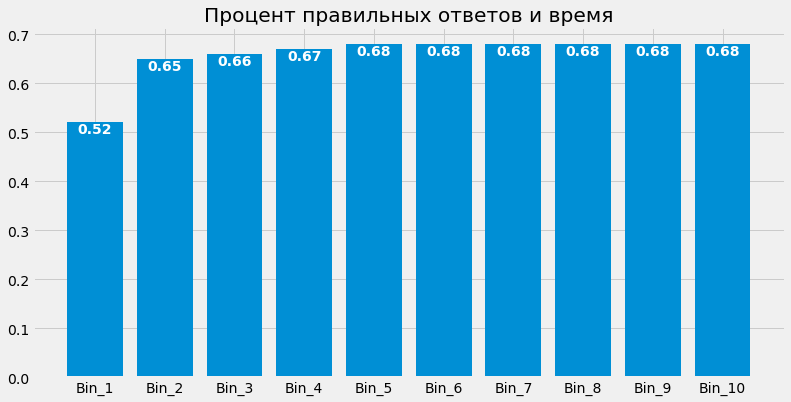

In [38]:
#Поделим данные по группам времени
bin_labels_5 = ['Bin_1', 'Bin_2', 'Bin_3', 'Bin_4', 'Bin_5', 'Bin_6', 'Bin_7', 'Bin_8', 'Bin_9', 'Bin_10']
train['ts_bin'] = pd.qcut(train['timestamp'], q=10, labels=bin_labels_5)

#функция для подсчета процента правильных ответов
def correct(field):
    correct = train[train.answered_correctly != -1].groupby([field, 'answered_correctly'], as_index=False).size()
    correct = correct.pivot(index= field, columns='answered_correctly', values='size')
    correct['Percent_correct'] = round(correct.iloc[:,1]/(correct.iloc[:,0] + correct.iloc[:,1]),2)
    correct = correct.sort_values(by = "Percent_correct", ascending = False)
    correct = correct.iloc[:,2]
    return(correct)
#Упорядочим данные
bins_correct = correct("ts_bin")
bins_correct = bins_correct.sort_index()

fig = plt.figure(figsize=(12,6))
plt.bar(bins_correct.index, bins_correct.values)
for i, v in zip(bins_correct.index, bins_correct.values):
    plt.text(i, v, v, color='white', fontweight='bold', fontsize=14, va='top', ha='center')
plt.title("Процент правильных ответов и время")
plt.xticks(rotation=0)
plt.show()

Видно что с "опытом" количество правильных ответов увеличивается

Проверим есть ли зависимость между количеством отвеченных вопросов и процентом правильных ответов

In [32]:
user_percent = train[train.answered_correctly != -1].groupby('user_id')['answered_correctly'].agg(Mean='mean', Answers='count')
print(f'Максимальное количество вопросов на которые ответил пользователь {user_percent.Answers.max()}')

Максимальное количество вопросов на которые ответил пользователь 17609


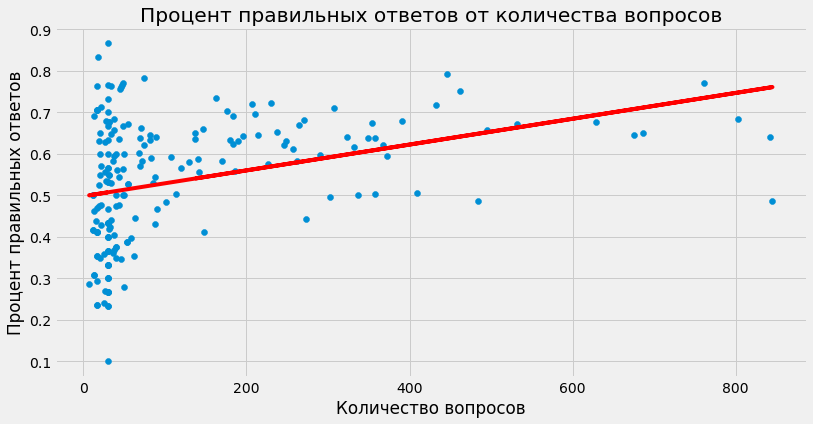

In [36]:
user_percent = user_percent.query('Answers <= 1000').sample(n=200, random_state=1)

fig = plt.figure(figsize=(12,6))
x = user_percent.Answers
y = user_percent.Mean
plt.scatter(x, y, marker='o')
plt.title("Процент правильных ответов от количества вопросов")
plt.xticks(rotation=0)
plt.xlabel("Количество вопросов")
plt.ylabel("Процент правильных ответов")
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

plt.show()

Как видно зависимость такая есть, хотя она и довольно предсказуема.

Посмотрим помогал ли просмотр лекций правильно отвечать на вопросы

False    244050
True     149606
Name: Watches_lecture, dtype: int64


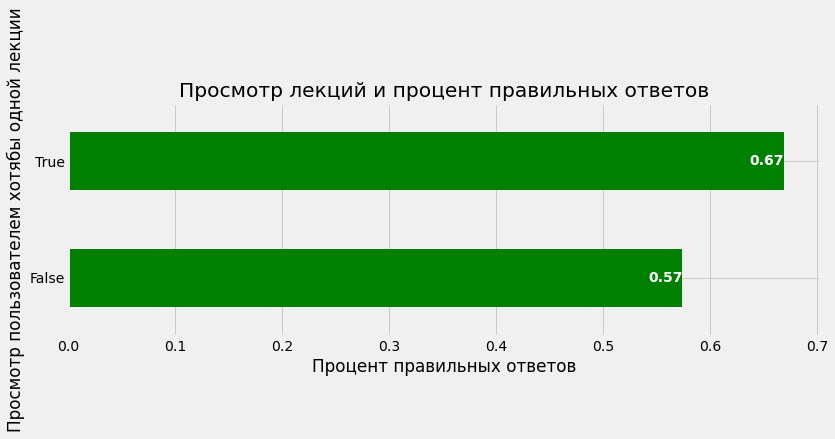

In [43]:
user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['Watches_lecture'] = np.where(user_lect.Lecture > 0, True, False)

watches_l = user_lect.groupby("Watches_lecture").agg({'Wrong': ['sum'], 'Right': ['sum']})
print(user_lect.Watches_lecture.value_counts())

watches_l['Percent_correct'] = watches_l.Right/(watches_l.Right + watches_l.Wrong)

watches_l = watches_l.iloc[:,2]

fig = plt.figure(figsize=(12,4))
watches_l.plot.barh(color='green')
for i, v in zip(watches_l.index, watches_l.values):
    plt.text(v, i, round(v,2), color='white', fontweight='bold', fontsize=14, ha='right', va='center')

plt.title("Просмотр лекций и процент правильных ответов")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Просмотр пользователем хотябы одной лекции")
plt.xticks(rotation=0)
plt.show()



Действительно просмотр лекций увеличил процент правильных ответов

Проверим помогало ли пользователем объяснение вопросов.

prior_question_had_explanation
False     9193234
True     89685560
<NA>       392506
Name: (answered_correctly, count), dtype: int64


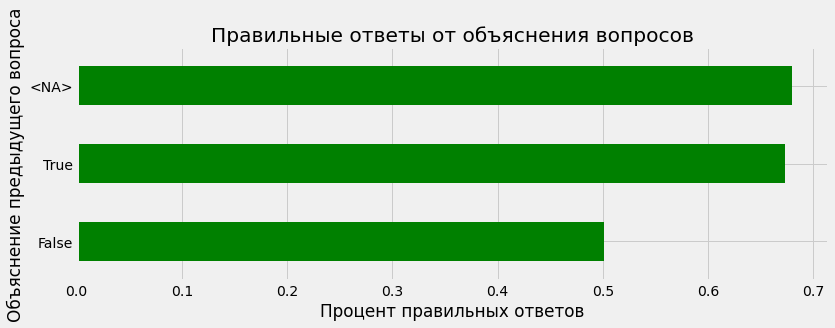

In [42]:
pq = train[train.answered_correctly != -1].groupby(['prior_question_had_explanation'], 
                                                   dropna=False).agg({'answered_correctly': ['mean', 'count']})
print(pq.iloc[:,1])
pq = pq.iloc[:,0]

fig = plt.figure(figsize=(12,4))
pq.plot.barh(color='green')

plt.title("Правильные ответы от объяснения вопросов")
plt.xlabel("Процент правильных ответов")
plt.ylabel("Объяснение предыдущего вопроса")
plt.xticks(rotation=0)
plt.show()



И этот показатель "увеличил" количество правильных ответов